## Non-parametric regression & Kernel estimation

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import scipy.stats

import matplotlib.pylab as plt

from sklearn.neighbors.kde import KernelDensity
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge, pairwise_kernels

from statsmodels.nonparametric.kernel_regression import KernelReg

%matplotlib inline 

In [2]:
sns.set_style('whitegrid')

### Exercise 1

* Load the data on fragments of glass collected in forensic work from glass.txt.
* Estimate the density of the first variable (refractive in-dex) using a histogram and use a kernel density estimator (you can use histograms from numpy and kernel density estimators from sklearn). Use cross-validation to choose the amount of smoothing.
* Experiment with different binwidths and bandwidths.
* Plot the obtained densities.

In [3]:
# ========================= Your code here =========================

data = np.loadtxt('glass.txt', skiprows=1, usecols=[i for i in range(1, 10)])
refl_idx = data[:, 0]

In [4]:
def plot_hist_dens (data, bins):
    plt.figure()
    sns.distplot(data,
                 bins=bins, kde_kws={"color": "g", "lw": 1.8, "label": "KDE"},
                   hist_kws={"linewidth": 1.3,
                             "alpha": .41, "label": "Histogram"})

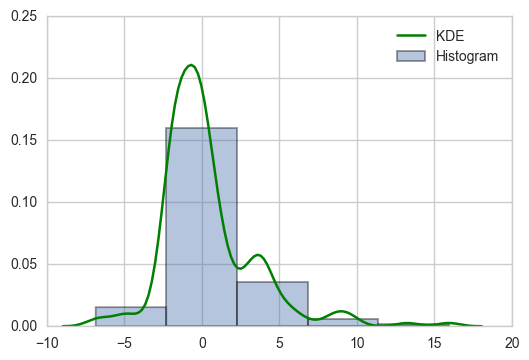

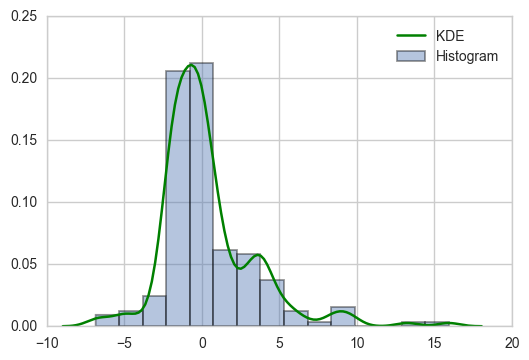

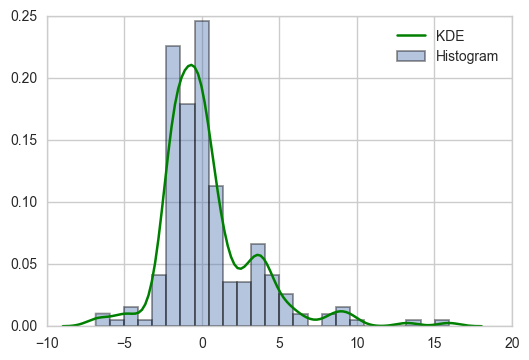

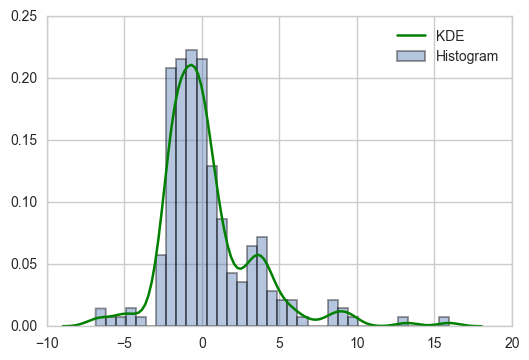

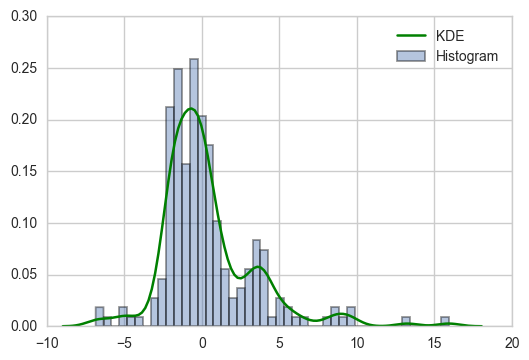

In [5]:
for bins in np.arange(5, 55, 10):
    plot_hist_dens(refl_idx, bins)

In [6]:
params = {'bandwidth': np.linspace(0.1, 10, 40)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(refl_idx.reshape((-1, 1)))
best_band = grid.best_params_['bandwidth']

x_ = np.linspace(np.min(refl_idx), np.max(refl_idx), 1000)
log_dens = grid.best_estimator_.score_samples(x_.reshape(-1, 1))

In [7]:
grid.best_estimator_.bandwidth

1.6230769230769231

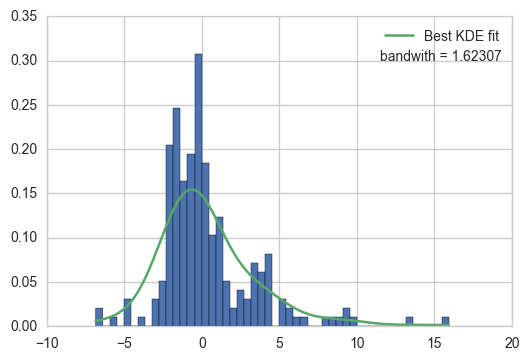

In [8]:
plt.hist(refl_idx, bins=50, normed= 1)
plt.plot(x_, np.exp(log_dens), '-', lw=1.8, label="Best KDE fit")

plt.text(11.5, .3, 'bandwith = 1.62307')
plt.legend(loc='best')

### Exercise 2

* Let $Y$ be refractive index and let $x$ be aluminum content (the fourth variable).
* Perform a nonparametric regression to fit the model $Y=f(x)+ \epsilon$. Use cross-validation to estimatethe bandwidth.
* Visualize your model and training data.

In [9]:
# ========================= Your code here =========================
Y = data[:, 0]
x = data[:, 3]

We will try to use in this problem both parametric and non-parametric approaches and compare them with each other. 

### Simple Linear regression

In [10]:
reg = linear_model.LinearRegression()
reg.fit(x.reshape(-1, 1), Y.reshape(-1, 1))
print "Coefs are: ", reg.coef_[0], reg.intercept_

Coefs are:  [-2.47760639] [ 3.94533024]


In [11]:
print "R^2 of linear regression: ", reg.score(x.reshape(-1, 1), Y.reshape(-1, 1))

R^2 of linear regression:  0.16591449804


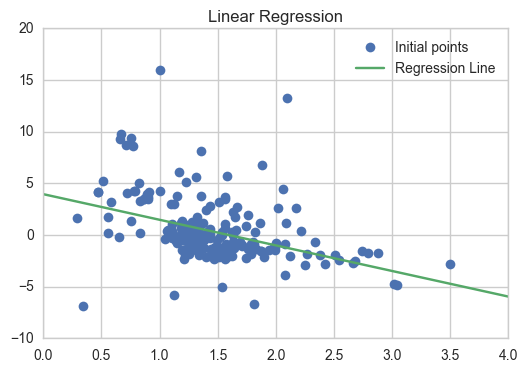

In [12]:
x_ = np.linspace(0, 4, 50)
#sns.jointplot(x, Y)
plt.plot(x, Y, 'o', label = "Initial points")
plt.plot(x_, (reg.intercept_ + reg.coef_ * x_)[0], label = "Regression Line")
plt.legend(loc='best')
plt.title("Linear Regression")

The performance is very poor, which is pretty obvious, because it is the simplest possible model.

### Non-parametric regression

In this method the kernel was estimated during the fitting.

In [13]:
kreg = KernelReg(exog=x, endog=Y, var_type='c', bw='cv_ls')
kreg_aic = KernelReg(exog = x, endog=Y, var_type='c', bw = 'aic')
print "R^2 of the regression is: ", kreg.r_squared(), "with cross-validated bandwidth: ", kreg.bw[0]
print "R^2 of the regression is: ", kreg_aic.r_squared(), "with AIC optimized bandwidth: ", kreg_aic.bw[0]

R^2 of the regression is:  0.311604722456 with cross-validated bandwidth:  0.258378687691
R^2 of the regression is:  0.33986742216 with AIC optimized bandwidth:  0.160146833992


We improved the $R^2$ score two times, and now it looks like a better fit than in case of pure linear regression. 

In [14]:
class NadarayaWatson(BaseEstimator):
    
    def __init__(self, init_bandwidth=None):
        self.bandwidth = init_bandwidth
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        mse = np.empty_like(self.bandwidth, dtype=np.float)
        for i, gamma in enumerate(self.bandwidth):
            K = pairwise_kernels(self.X, self.X, metric='rbf',
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()
        self.bandwidth = self.bandwidth[np.nanargmin(mse)]
        #print "Self bandwidth: %g" %self.bandwidth
        return self
        
    def predict(self, X):
        K = pairwise_kernels(self.X, X, metric='rbf', gamma=self.bandwidth)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

In [15]:
nw = NadarayaWatson(init_bandwidth=np.logspace(-2, 2, 100))
nw.fit(x.reshape(-1, 1), Y)

NadarayaWatson(init_bandwidth=None)

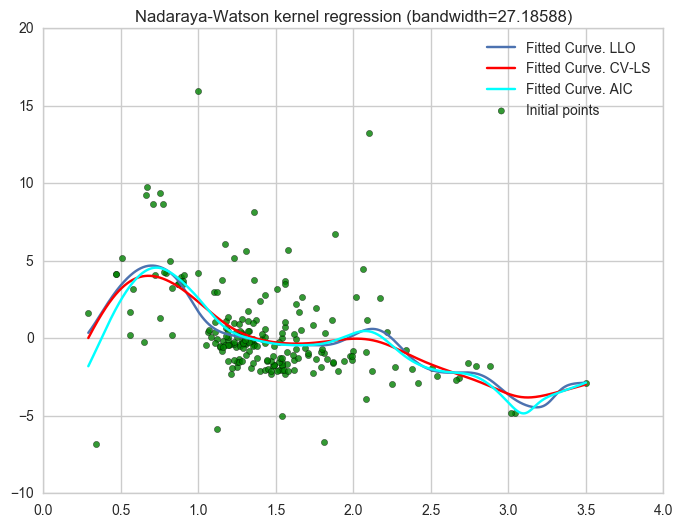

In [16]:
plt.figure(figsize=(8, 6))
_x = np.linspace(np.min(x), np.max(x), 1000).reshape((-1, 1))

plt.scatter(x, Y, alpha = .8, label = 'Initial points', c = 'green')
plt.plot(_x, nw.predict(_x), '-', label = 'Fitted Curve. LLO')

plt.plot(np.linspace(np.min(x), np.max(x), 1000), 
         kreg.fit(np.linspace(np.min(x), np.max(x), 1000))[0], '-', label = 'Fitted Curve. CV-LS',
        c = 'red')

plt.plot(np.linspace(np.min(x), np.max(x), 1000), 
         kreg_aic.fit(np.linspace(np.min(x), np.max(x), 1000))[0], '-', label = 'Fitted Curve. AIC',
        c = 'cyan')


plt.legend(loc='best')
plt.title('Nadaraya-Watson kernel regression (bandwidth={0:0.5f})'.format(nw.bandwidth))